# InternVLA-N1 Model Testing Notebook

This notebook is used to test the InternVLA-N1 model's generation performance by reading images and instructions from local folders and running the model's generate method. If you only want 

## 1. Import Required Libraries

In [ ]:
import sys
import os
import glob
from pathlib import Path

import numpy as np
from PIL import Image
import torch

# Add project path
project_root = Path('/home/pjlab/yq_ws/InternNav')
sys.path.insert(0, str(project_root))

from internnav.agent.internvla_n1_agent_realworld import InternVLAN1AsyncAgent

## 2. Configure Parameters

In [ ]:
class Args:
    def __init__(self):
        self.device = "cuda:0"
        self.model_path = "checkpoints/InternVLA-N1"
        self.resize_w = 384
        self.resize_h = 384
        self.num_history = 8
        self.camera_intrinsic = np.array([
            [386.5, 0.0, 328.9, 0.0],
            [0.0, 386.5, 244.0, 0.0],
            [0.0, 0.0, 1.0, 0.0],
            [0.0, 0.0, 0.0, 1.0]
        ])
        self.plan_step_gap = 8

args = Args()
print(f"Model path: {args.model_path}")
print(f"Device: {args.device}")
print(f"Image size: {args.resize_w}x{args.resize_h}")
print(f"History frames: {args.num_history}")

Model path: /home/pjlab/fengdelin/data/InternVLA-N1
Device: cuda:0
Image size: 384x384
History frames: 8


## 3. Initialize Agent

In [ ]:
print("Loading model...")
agent = InternVLAN1AsyncAgent(args)

# Warm up model
print("Warming up model...")
dummy_rgb = np.zeros((480, 640, 3), dtype=np.uint8)
dummy_depth = np.zeros((480, 640), dtype=np.float32)
dummy_pose = np.eye(4)
agent.reset()
agent.step(dummy_rgb, dummy_depth, dummy_pose, "hello", intrinsic=args.camera_intrinsic)
print("Model loaded successfully!")

## 4. Configure Test Data Path

In [4]:
# Configure data directory (single scene per folder)
scene_dir = '../../assets/realworld_sample_data1'

# Check if instruction file exists
instruction_path = os.path.join(scene_dir, 'instruction.txt')
if not os.path.exists(instruction_path):
    print(f"Error: instruction.txt not found in {scene_dir}")
else:
    print(f"Scene directory: {scene_dir}")
    
    # Read instruction
    with open(instruction_path, 'r') as f:
        instruction = f.read().strip()
    print(f"Instruction: {instruction}")
    
    # Get all debug_raw images
    rgb_paths = sorted(glob.glob(os.path.join(scene_dir, 'debug_raw_*.jpg')))
    print(f"\nFound {len(rgb_paths)} images")
    # Show first few image names
    print("\nFirst 5 images:")
    for i, path in enumerate(rgb_paths[:5]):
        print(f"  {i+1}. {os.path.basename(path)}")

Scene directory: ../../assets/realworld_sample_data1
Instruction: Turn around and walk out of this office. Turn towards your slight right at the chair. Move forward to the walkway and go near the red bin. You can see an open door on your right side, go inside the open door. Stop at the computer monitor.

Found 152 images

First 5 images:
  1. debug_raw_0000.jpg
  2. debug_raw_0001.jpg
  3. debug_raw_0002.jpg
  4. debug_raw_0003.jpg
  5. debug_raw_0004.jpg


In [5]:
from PIL import Image, ImageDraw, ImageFont
import cv2

def annotate_image(idx, image, llm_output, trajectory, pixel_goal, output_dir):
    image = Image.fromarray(image)#.save(f'rgb_{idx}.png')
    draw = ImageDraw.Draw(image)
    font_size = 20
    font = ImageFont.truetype("DejaVuSansMono.ttf", font_size)
    text_content = []
    text_content.append(f"Frame    Id  : {idx}")
    text_content.append(f"Actions      : {llm_output}" )
    max_width = 0
    total_height = 0
    for line in text_content:
        bbox = draw.textbbox((0, 0), line, font=font)
        text_width = bbox[2] - bbox[0]
        text_height = 26
        max_width = max(max_width, text_width)
        total_height += text_height

    padding = 10
    box_x, box_y = 10, 10
    box_width = max_width + 2 * padding
    box_height = total_height + 2 * padding

    draw.rectangle([box_x, box_y, box_x + box_width, box_y + box_height], fill='black')

    text_color = 'white'
    y_position = box_y + padding
    
    for line in text_content:
        draw.text((box_x + padding, y_position), line, fill=text_color, font=font)
        bbox = draw.textbbox((0, 0), line, font=font)
        text_height = 26
        y_position += text_height
    image = np.array(image)
    
    # Draw trajectory visualization in the top-right corner using matplotlib
    if trajectory is not None and len(trajectory) > 0:
        import matplotlib.pyplot as plt
        from matplotlib.backends.backend_agg import FigureCanvasAgg
        
        img_height, img_width = image.shape[:2]
        
        # Window parameters
        window_size = 200  # Window size in pixels
        window_margin = 0  # Margin from edge
        window_x = img_width - window_size - window_margin
        window_y = window_margin
        
        # Extract trajectory points
        traj_points = []
        for point in trajectory:
            if isinstance(point, (list, tuple, np.ndarray)) and len(point) >= 2:
                traj_points.append([float(point[0]), float(point[1])])
        
        if len(traj_points) > 0:
            traj_array = np.array(traj_points)
            x_coords = traj_array[:, 0]
            y_coords = traj_array[:, 1]
            
            # Create matplotlib figure
            fig, ax = plt.subplots(figsize=(2, 2), dpi=100)
            fig.patch.set_alpha(0.6)  # Semi-transparent background
            fig.patch.set_facecolor('gray')
            ax.set_facecolor('lightgray')
            
            # Plot trajectory
            # Coordinate system: x-axis points up, y-axis points left
            # Origin at bottom center
            ax.plot(y_coords, x_coords, 'b-', linewidth=2, label='Trajectory')
            
            # Mark start point (green) and end point (red)
            ax.plot(y_coords[0], x_coords[0], 'go', markersize=6, label='Start')
            ax.plot(y_coords[-1], x_coords[-1], 'ro', markersize=6, label='End')
            
            # Mark origin
            ax.plot(0, 0, 'w+', markersize=10, markeredgewidth=2, label='Origin')
            
            # Set axis labels
            ax.set_xlabel('Y (left +)', fontsize=8)
            ax.set_ylabel('X (up +)', fontsize=8)
            ax.invert_xaxis()
            ax.tick_params(labelsize=6)
            ax.grid(True, alpha=0.3, linewidth=0.5)
            
            # Set equal aspect ratio
            ax.set_aspect('equal', adjustable='box')
            
            # Add legend
            ax.legend(fontsize=6, loc='upper right')
            
            # Adjust layout
            plt.tight_layout(pad=0.3)
            
            # Convert matplotlib figure to numpy array
            canvas = FigureCanvasAgg(fig)
            canvas.draw()
            plot_img = np.frombuffer(canvas.tostring_rgb(), dtype=np.uint8)
            plot_img = plot_img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
            plt.close(fig)
            
            # Resize plot to fit window
            plot_img = cv2.resize(plot_img, (window_size, window_size))
            
            # Overlay plot on image
            image[window_y:window_y+window_size, window_x:window_x+window_size] = plot_img
    
    if pixel_goal is not None:
        cv2.circle(image, (pixel_goal[1], pixel_goal[0]), 5, (255, 0, 0), -1)
    image = Image.fromarray(image).convert('RGB')
    image.save(f'{output_dir}/rgb_{idx}_annotated.png')
    # to numpy array
    return np.array(image)

## 5. Run Model Testing

In [6]:
# Reset agent
agent.reset()
print(f"{'='*80}")
print(f"Processing scene: {os.path.basename(scene_dir)}")
print(f"Instruction: '{instruction}'")
print(f"Total images: {len(rgb_paths)}")
print(f"{'='*80}\n")

action_seq = []
look_down = False

save_dir = '../../test_data/'
# Process each image
for i, rgb_path in enumerate(rgb_paths):
    # Check if this is a look_down image
    look_down = ('look_down' in rgb_path)
    
    # Extract image ID from filename (e.g., debug_raw_0003.jpg -> 0003)
    basename = os.path.basename(rgb_path)
    if look_down:
        # e.g., debug_raw_0010_look_down.jpg -> 0010
        image_id = basename.replace('debug_raw_', '').replace('_look_down.jpg', '')
    else:
        # e.g., debug_raw_0003.jpg -> 0003
        image_id = basename.replace('debug_raw_', '').replace('.jpg', '')
        
    # Read RGB image
    rgb = np.asarray(Image.open(rgb_path).convert('RGB'))
    
    # Create dummy depth image (not available in test data)
    # !Note You must full in depth to model
    depth = np.zeros((rgb.shape[0], rgb.shape[1]), dtype=np.float32)
    
    # Create dummy camera pose
    camera_pose = np.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1]
    ])
    
    # Run model or just save image
    # print(f"[{i+1}/{len(rgb_paths)}] Running model inference: {os.path.basename(rgb_path)}")
    dual_sys_output = agent.step(
        rgb, 
        depth, 
        camera_pose, 
        instruction, 
        intrinsic=args.camera_intrinsic,
        look_down=look_down
    )
    
    # Print output results
    if dual_sys_output.output_action is not None and dual_sys_output.output_action != []:
        print(f"  Output action: {dual_sys_output.output_action}")
        # action_seq.extend(s2_output.output_action)
    else:
        
        print(f"output_trajectory: {dual_sys_output.output_trajectory.tolist()}")
        if dual_sys_output.output_pixel is not None:
            print(f"output_pixel: {dual_sys_output.output_pixel}")
            annotate_image(image_id, rgb, 'traj', dual_sys_output.output_trajectory.tolist(), dual_sys_output.output_pixel, save_dir)


print(f"\nScene {os.path.basename(scene_dir)} completed!")


reset called 0
Processing scene: realworld_sample_data1
Instruction: 'Turn around and walk out of this office. Turn towards your slight right at the chair. Move forward to the walkway and go near the red bin. You can see an open door on your right side, go inside the open door. Stop at the computer monitor.'
Total images: 152

llm output 1
output 1  →→→→ cost: 0.18848490715026855s
  Output action: [3, 3, 3, 3]
llm output 2
output 2  →→→→ cost: 0.19171738624572754s
  Output action: [3, 3, 3, 3]
llm output 3
output 3  →→→→ cost: 0.21631813049316406s
  Output action: [3, 3, 3, 3]
llm output 4
output 4  →→→→ cost: 0.24959087371826172s
  Output action: [3, 3, 3, 3]
llm output 5
output 5  →→→→ cost: 0.27814221382141113s
  Output action: [3, 3, 3, 3]
llm output 6
output 6  →→→→ cost: 0.3256256580352783s
  Output action: [3, 3, 3, 3]
llm output 7
output 7  →→→→ cost: 0.33748435974121094s
  Output action: [3, 3, 3, 3]
llm output 8
output 8  →→→→ cost: 0.3901810646057129s
  Output action: [3, 3,

/tmp/ipykernel_1290188/3632390943.py:99: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  plot_img = np.frombuffer(canvas.tostring_rgb(), dtype=np.uint8)


output_trajectory: [[0.0, 0.0], [0.09279656410217285, 0.02799360454082489], [0.18273282051086426, 0.06558303534984589], [0.2602475881576538, 0.12235669791698456], [0.3276060223579407, 0.1891135424375534], [0.3894712030887604, 0.2599252015352249], [0.4465528391301632, 0.32920683920383453], [0.5057411454617977, 0.3987569957971573], [0.5505012534558773, 0.4540949612855911], [0.5964294336736202, 0.5107561349868774], [0.6404382549226284, 0.5645915120840073], [0.6733292005956173, 0.6053401380777359], [0.7063777111470699, 0.6442867070436478], [0.7293478511273861, 0.6704290807247162], [0.7501128874719143, 0.6937905550003052], [0.7656535319983959, 0.7139713987708092], [0.7689116708934307, 0.7206515595316887], [0.7702508084475994, 0.7240036502480507], [0.7722646109759808, 0.7268638014793396], [0.7744337879121304, 0.7294351607561111], [0.7765444777905941, 0.7313374280929565], [0.7788044027984142, 0.7336654588580132], [0.7806785367429256, 0.73589151725173], [0.7813619114458561, 0.7369517348706722]

Token indices sequence length is longer than the specified maximum sequence length for this model (8527 > 8192). Running this sequence through the model will result in indexing errors


llm output 119
output 119  306 277 cost: 0.8512279987335205s
output_trajectory: [[0.0, 0.0], [0.06898629665374756, 0.0011551231145858765], [0.1343308687210083, -0.0013894736766815186], [0.1733262538909912, -0.004421979188919067], [0.18759621679782867, -0.009408362209796906], [0.19757671654224396, -0.015361122786998749], [0.20129486918449402, -0.021836034953594208], [0.20395539700984955, -0.028396733105182648], [0.20775814354419708, -0.0358876958489418], [0.21088816970586777, -0.041240379214286804], [0.21428684145212173, -0.04623761773109436], [0.21434109658002853, -0.04683724045753479], [0.21423212438821793, -0.04712940752506256], [0.2138982191681862, -0.04736993461847305], [0.21379121392965317, -0.04785124026238918], [0.21356404572725296, -0.04826187156140804], [0.21338938921689987, -0.04855707846581936], [0.2130732461810112, -0.04893321357667446], [0.2130468301475048, -0.04923407547175884], [0.21293387934565544, -0.049549927935004234], [0.21301991865038872, -0.04988079331815243], [0.

# 6.Visualize Results

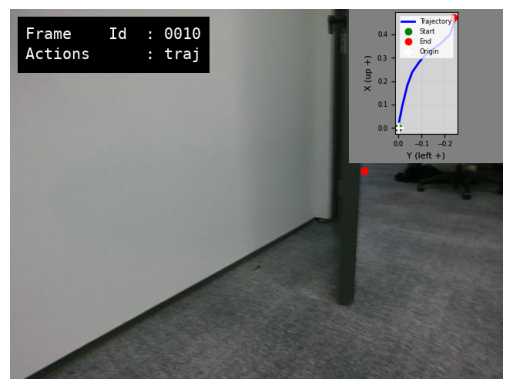

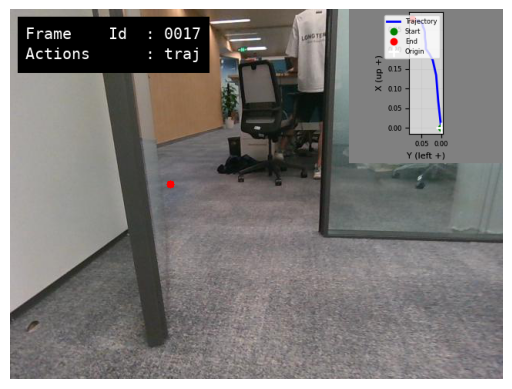

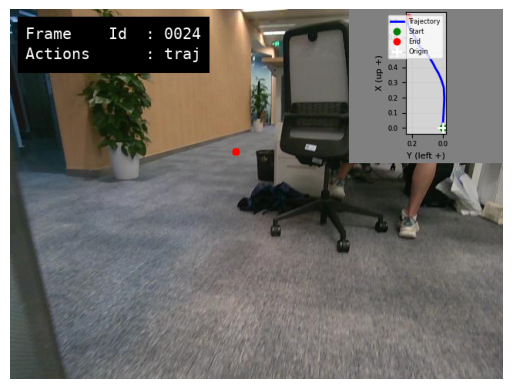

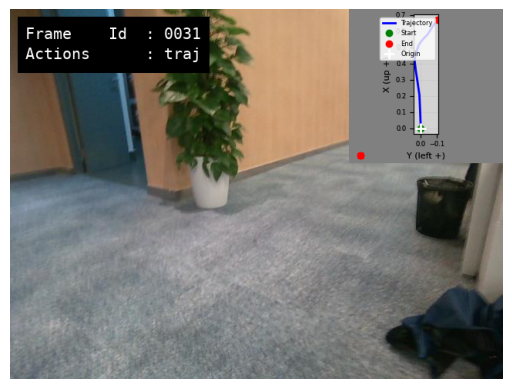

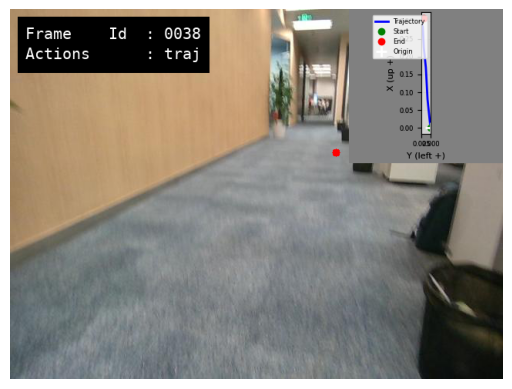

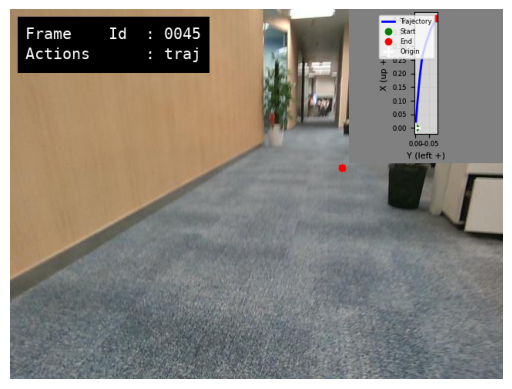

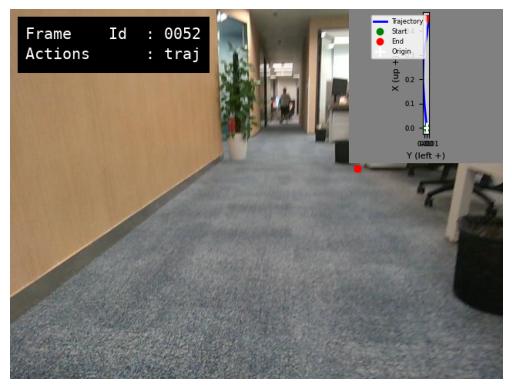

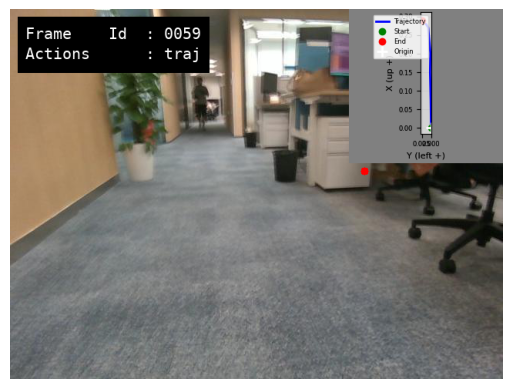

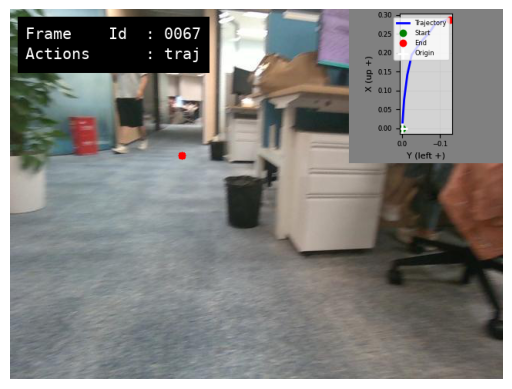

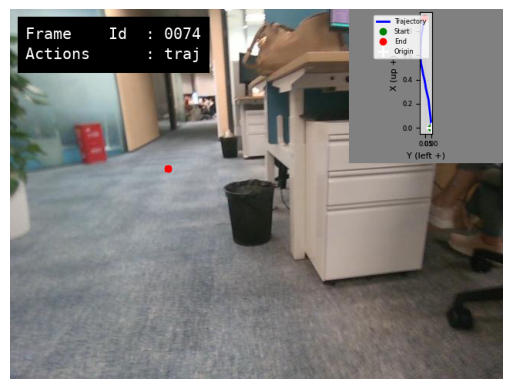

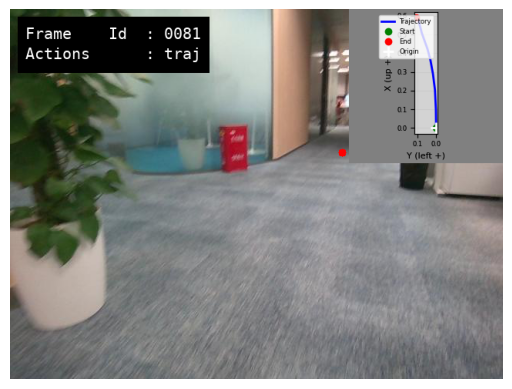

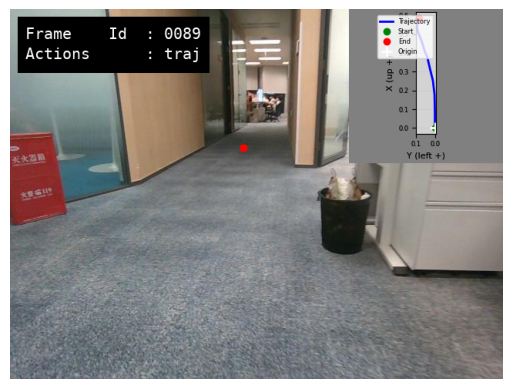

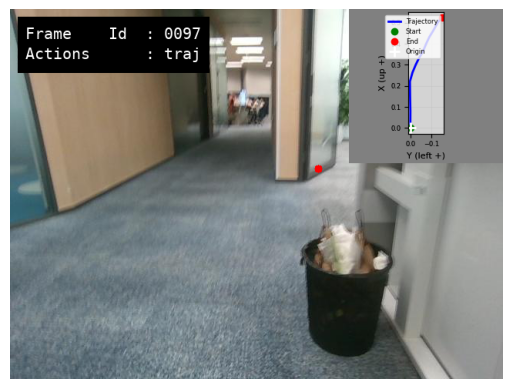

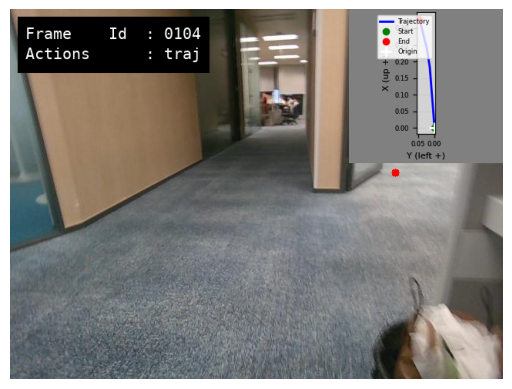

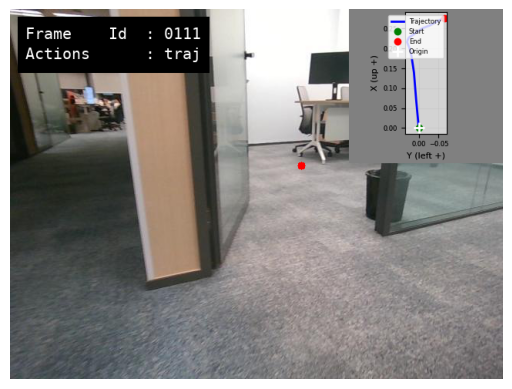

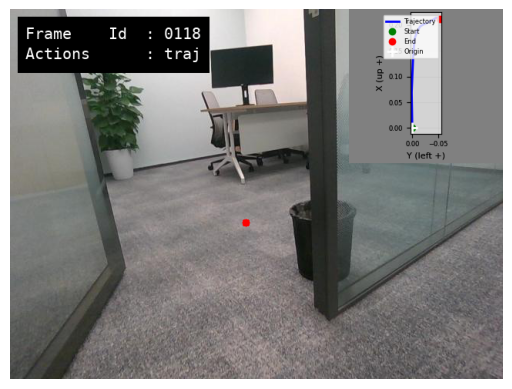

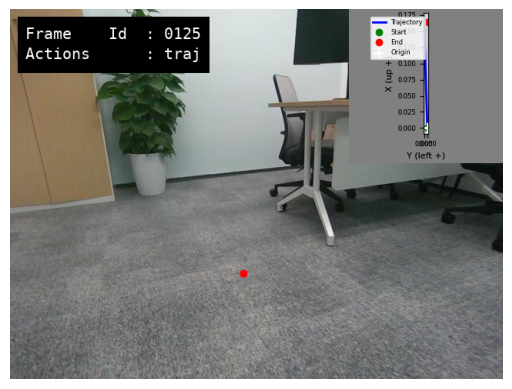

: 

In [ ]:

import glob
from PIL import Image
import matplotlib.pyplot as plt

for img_path in sorted(glob.glob(f'{save_dir}/*_annotated.png')):
    plt.imshow(Image.open(img_path))
    plt.axis('off')
    plt.show()